In [110]:
import rosbag
from geometry_msgs.msg import Vector3
import rospy

bag = rosbag.Bag('/home/miguel/catkin_ws/src/crazyflie/crazyflie_controller/src/data/LQR_after_trim.bag')
bag = rosbag.Bag('/home/miguel/catkin_ws/src/crazyflie/crazyflie_controller/src/data/LQR_after_amax_trim.bag')


import matplotlib.pyplot as plt

position_optitrack = []
position_state_estimate = []
vel_optitrack = []
vel_state_estimate = []
position_gaussian_error = []
control_input = []

for topic, msg, t in bag.read_messages(topics=['position_Optitrack', 'position_estimate_topic', 'vel_Optitrack', 'vel_estimate_topic', 'control_input']):
    
    if topic == 'position_Optitrack':
        position_optitrack.append((msg.x, msg.y, msg.z))

    if topic == 'position_estimate_topic':
        position_state_estimate.append((msg.x, msg.y, msg.z))

    if topic == 'vel_Optitrack':
        vel_optitrack.append((msg.x, msg.y, msg.z))

    if topic == 'vel_estimate_topic':
        vel_state_estimate.append((msg.x, msg.y, msg.z))

    if topic == 'control_input':
        control_input.append((msg.x, msg.y, msg.z))

# After processing, close the bag
bag.close()


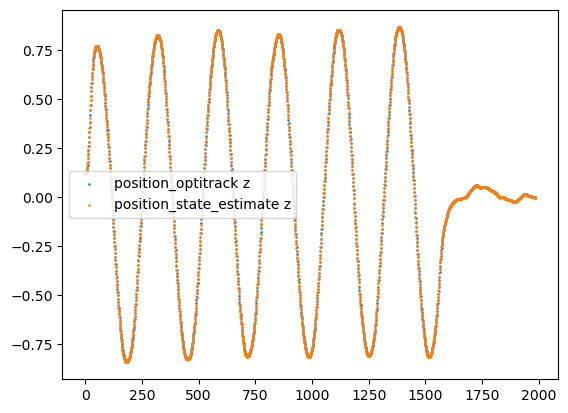

In [111]:
# Plotting example
plt.scatter(range(len(position_optitrack)), [x[1] for x in position_optitrack], label='position_optitrack z', s=0.7)
plt.scatter(range(len(position_state_estimate)), [x[1] for x in position_state_estimate], label='position_state_estimate z', s=0.7)
# plt.scatter(range(len(position_gaussian_error)), [x[2] for x in position_gaussian_error], label='position_gaussian_error z', s=0.7)
# Add more plots as needed
# plt.ylim(0.92, 1.02)
plt.legend()
plt.show()

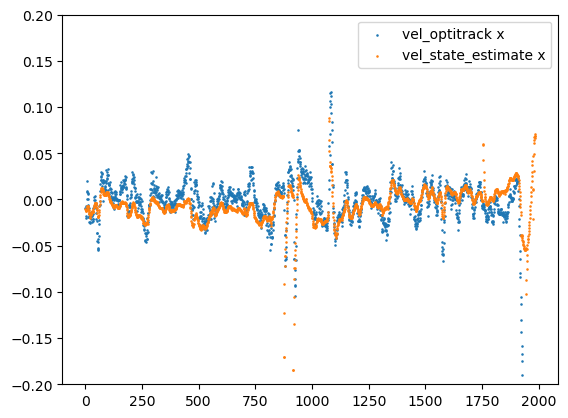

In [112]:
# Plotting example
plt.scatter(range(len(vel_optitrack)), [x[2] for x in vel_optitrack], label='vel_optitrack x', s=0.7)
plt.scatter(range(len(vel_state_estimate)), [(x[2]) for x in vel_state_estimate], label='vel_state_estimate x', s=0.7)
plt.ylim(-0.2, 0.2)
# Add more plots as needed
plt.legend()
plt.show()

In [113]:
import numpy as np

class MyKF:
    def __init__(self, A, B, C, D, Rw, Rv, initial_state, initial_error_covariance, Ts):
        self.A = (np.eye(A.shape[0]) + np.array(A)*Ts)
        self.B = np.array(B)*Ts

        self.C = np.array(C)
        self.D = np.array(D)
        self.Ts = Ts
        self.Rw = np.array(Rw)
        self.Rv = np.array(Rv)
        self.state_estimate = np.array(initial_state)
        self.error_covariance = np.array(initial_error_covariance)

    def update(self, measurement, control_input):
        measurement = np.array(measurement)
        control_input = np.array(control_input)

        # Innovation
        innovation = measurement - self.C @ self.state_estimate - self.D @ control_input
        innovation_covariance = self.C @ self.error_covariance @ self.C.T + self.Rv

        # Correction
        kalman_gain = self.error_covariance @ self.C.T @ np.linalg.pinv(innovation_covariance)
        self.state_estimate = self.state_estimate + kalman_gain @ innovation
        self.error_covariance = (np.eye(self.A.shape[0]) - kalman_gain @ self.C) @ self.error_covariance

        # Prediction
        self.old_state = self.state_estimate
        self.state_estimate = self.A @ self.state_estimate + self.B @ control_input
        self.error_covariance = self.A @ self.error_covariance @ self.A.T + self.Rw

        self.state_estimate[2] = self.old_state[2] + self.Ts * self.old_state[5]
        self.state_estimate[5] = self.old_state[5] + self.Ts * (1/0.035 * control_input[2] - 9.81)

        return self.state_estimate

In [154]:
from filterpy.kalman import KalmanFilter
import numpy as np

m = 0.31  # mass of the drone in kg
g = 9.81  # gravity
kvx = 0.0
kvy = 0.0
kvz = 0

A = np.array([[0, 0, 0, 1, 0, 0],
                    [0, 0, 0, 0, 1, 0],
                    [0, 0, 0, 0, 0, 1],
                    [0, 0, 0, -kvx/m, 0, 0],
                    [0, 0, 0, 0, -kvy/m, 0],
                    [0, 0, 0, 0, 0, -kvz/m]])

B = np.array([[0, 0, 0],
                    [0, 0, 0],
                    [0, 0, 0],
                    [g, 0, 0],
                    [0, g, 0],
                    [0, 0, 1/m]])

C = np.array([[1, 0, 0, 0, 0, 0],
                    [0, 1, 0, 0, 0, 0],
                    [0, 0, 1, 0, 0, 0]])

D = np.zeros((C.shape[0], B.shape[1]))

r_xyz = 0.001
r_xyz_dot = 10
r_optitrack = 0.5

# Etate matrix
Rw = np.block([
    [r_xyz**2 * np.eye(3), np.zeros((3, 3))],
    [np.zeros((3, 3)), r_xyz_dot**2 * np.eye(3)]
])

Rv = np.array(r_optitrack**2 * np.eye(3))

error_covariance = np.array([[0.1, 0, 0, 0, 0, 0],
                            [0, 0.1, 0, 0, 0, 0],
                            [0, 0,0.1, 0, 0, 0],
                            [0, 0, 0, 0.1, 0, 0],
                            [0, 0, 0, 0, 0.1, 0],
                            [0, 0, 0, 0, 0, 0.1]])


Ts = 1/30
initial_state = [position_optitrack[0][0], position_optitrack[0][1], position_optitrack[0][2], vel_optitrack[0][0], vel_optitrack[0][1], vel_optitrack[0][2]]

my_kalman_filter = MyKF(A, B, C, D, Rw, Rv, initial_state, error_covariance, Ts)

A = (np.eye(A.shape[0]) + np.array(A)*Ts)
B = np.array(B)*Ts

f = KalmanFilter(dim_x=A.shape[0], dim_z=C.shape[0])

# Assign your matrices
f.F = A  # State Transition matrix
f.B = B  # Control Input matrix
f.H = C  # Measurement function
f.Q = Rw # Process Noise Covariance
f.R = Rv # Measurement Noise Covariance
f.x = initial_state
f.P = error_covariance # Initial Covariance Estimate

kalman_states = [initial_state]
my_kalman_states = [initial_state]

for i in range(len(position_optitrack) - 1):
    f.predict(u=control_input[i+1])
    
    # When a new measurement is received
    position = np.array([position_optitrack[i+1][0], position_optitrack[i+1][1], position_optitrack[i+1][2]])
    f.update(position)

    my_current_state_estimate = my_kalman_filter.update(position, control_input[i+1])
    my_kalman_states.append(my_current_state_estimate)

    # Now f.x holds the updated state estimate
    current_state_estimate = f.x.copy()
    kalman_states.append(current_state_estimate)

(-1, 1)

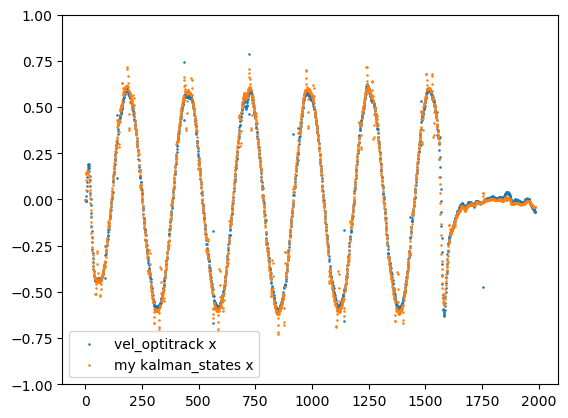

In [158]:
# plt.scatter(range(len(position_optitrack)), [x[0] for x in position_optitrack], label='position_optitrack z', s=0.7)
plt.scatter(range(len(vel_optitrack)), [x[0] for x in vel_optitrack], label='vel_optitrack x', s=0.7)
plt.scatter(range(len(kalman_states)), [x[3] for x in my_kalman_states], label='my kalman_states x', s=0.7)
# plt.scatter(range(len(kalman_states)), [x[4] for x in kalman_states], label='kalman_states x', s=0.7)
plt.legend()
#plt.ylim(-0.2, 0.2)
plt.ylim(-1, 1)
